In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [0]:
wine_df = pd.read_csv('/dbfs/FileStore/tables/hirak/R&R/NLP/winemag_data_first150k.csv')
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


####Exploratory Data Analysis
The first check is to see where values are missing. Luckily there isn't any data missing in the description and variety columns, which are the main columns I need for this analysis. There are 5 missing values for country that I originally filled in by looking at which winery was listed with these missing values, then looked up other entries with that same winery to determine country. I wanted to do this because I was thinking of exploring what words are used to describe wines from various countries but scratched this idea and decided to focus only on the different varieties.

In [0]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


As we can see, there are some duplicates with the descriptions. Although the duplicates won't affect the averaging used to find the kMeans centroids, I still decided to remove them because I only need unique descriptions to perform the clustering. Note that dropping duplicates will still keep one of those entries in the set.

In [0]:
wine_df[wine_df['description'].duplicated(keep = False)].sort_values('description').head(20)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
62345,62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
74993,74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
18803,18803,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
26530,26530,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
84730,84730,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
53110,53110,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
107351,107351,France,. From a small south-facing parcel next to the...,Trie Spéciale,91,38.0,Loire Valley,Savennières,NaN,Chenin Blanc,Domaine des Baumard
65231,65231,France,. From a small south-facing parcel next to the...,Trie Spéciale,91,38.0,Loire Valley,Savennières,NaN,Chenin Blanc,Domaine des Baumard
43074,43074,Germany,. Lemon zest and exotic spices enliven the nos...,Bernkasteler Badstube Kabinett,86,22.0,Mosel,NaN,NaN,Riesling,Dr. Pauly Bergweiler


In [0]:
wine_df = wine_df.drop_duplicates('description')

If we list out all the unique varieties in this dataset, we find that there are a ton of them here. However, with kMeans, I want to limit the number of wine varieties to the number of clusters because I'm hoping the algorithm will be able to find individual clusters or average descriptions for each type of wine. If I limit wine varieties to those where there are more than 1500 entries in the dataset, 15 types are narrowed down. I will create a new dataframe and use descriptions only from these 15 kinds of wines.

P.S.: I believe we can even use the elbow method to determine the no. of clusters, I haven't used it here since it was a quick analysis and I wasn't entirely sure if the elbow method could be applied for non-numerical data.

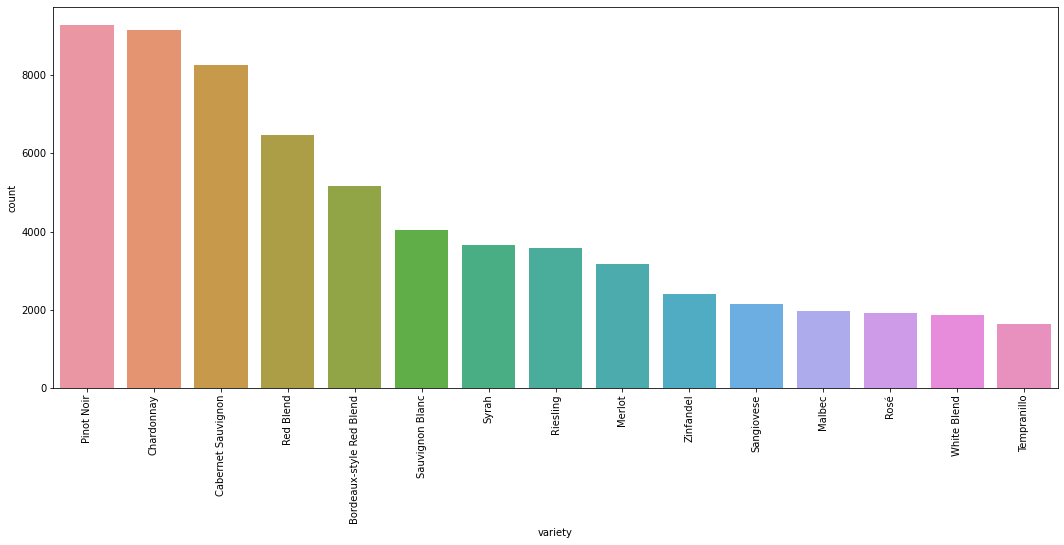

In [0]:
variety_df = wine_df.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (18, 7))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [0]:
variety_df['variety'].unique()

Out[18]: array(['Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Rosé', 'Syrah',
       'Sangiovese', 'Red Blend', 'Riesling', 'White Blend', 'Zinfandel',
       'Bordeaux-style Red Blend', 'Merlot'], dtype=object)

#####Natural Language Processing

In Natural Language Processing, there is a term called stop words. These are tokens (NLP's definition for characters or groups of characters including words, punctuation, etc.) that are used frequently in the texts of the group of documents, or corpus, but don't really give much meaning or context to what they're being used in; they're generally used more for grammatical purposes. Examples of stop words are 'the', 'is', 'are', etc. There might be additional words that do not give much meaning to the text depending on what the situation is. I will discuss more stop words I could have used for this analysis in the conclusion but for now, I will use the English stop words list that is defaulted in the sklearn library in addition to some punctuation. When our text is being vectorized, the tokens included in the stop words list will not be included in the vectorization. Having stop words also helps us keep down the feature space.

To vectorize the tokens of each description, sklearn has a count vectorizer or tf-idf (term frequency-inverse document frequency) vectorizer object that will do all of this for us. The count vectorizer simply creates a vector of counts of each word in each description. The tf-idf vectorizer, on the otherhand, takes it further by creating frequency vectors that account for how important each token is relative to the document it is in and relative to the corpus. A word might appear more than others in the same document, making it important to that piece of text. However, if that highly frequented word is in many of the other documents in the corpus, then that word does not really help distinguish that single document from the others. For this analysis, I have used the tf-idf vectorizer.

In [0]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

Both the count vectorizer and tf-idf vectorizer in sklearn have a method called get_feature_names(). This returns a list of all the tokens in the corpus that were vectorized for each document (note that each document will not contain all of the words extracted from the entire group so the entries in their vectors will be 0 for these tokens).

Below is a subset of the tokens that were vectorized. You can see that different forms of words show up in the list such as 'abrasive', 'abrasiveness', and 'absorb', 'absorbed', 'absorbs'. In many cases these different forms of the same word are redundant, and yes, you guessed right, unnecessarily extend our feature space. Sklearn's word vectorizers do not account for these unnecessary forms by default and that is why we see them in the list below.

In [0]:
word_features = vectorizer.get_feature_names()
word_features[550:575]

/databricks/python/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Out[20]: ['aboard',
 'abondante',
 'abound',
 'abounding',
 'abounds',
 'abouriou',
 'abracadabra',
 'abrasive',
 'abrasiveness',
 'abreu',
 'abroad',
 'abrupt',
 'abruptly',
 'abruzzi',
 'abruzzo',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbs',
 'abstberg',
 'absurd',
 'abtsberg']

In [0]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

After writing the function, I pass it through as an argument when instantiating the vectorizer.

In [0]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

/databricks/python/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


Out[22]: ["'s",
 "a'",
 "a'plenti",
 'aa',
 'aah',
 'aand',
 'aaron',
 'abacela',
 'abad',
 'abadia',
 'abandon',
 'abarbanel',
 'abbacchio',
 'abbay',
 'abbey',
 'abbinar',
 'abboccato',
 'abbott',
 'abbrevi',
 'abbuoto',
 'abc',
 'abeill',
 'abeja',
 'abernathi',
 'aberr',
 'abetina',
 'abey',
 'abil',
 'abl',
 'abli',
 'abnorm',
 'aboard',
 'abondant',
 'abound',
 'abouriou',
 'abov',
 'abracadabra',
 'abras',
 'abreu',
 'abroad',
 'abrupt',
 'abruzzi',
 'abruzzo',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abstberg',
 'absurd',
 'abtsberg']

So far I've adjusted the stop words, included stemming, and further limited our token feature space with regular expressions. Below, I take it one step further by adjusting the max_features parameter in the tf-idf vectorizer, which selects only the top max_features tokens ordered by their frequencies in the corpus to be included in the vectorizing.

In [0]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

In [0]:
variety_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


#####kMeans Clustering
Now that the text preprocessing is done, I can finally apply the kMeans algorithm to cluster the description vectors.

In [0]:
kmeans = KMeans(n_clusters = 15, n_init = 5)
kmeans.fit(X3)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe4c9173310>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Out[29]: KMeans(n_clusters=15, n_init=5)

The model has a cluster centers attribute that returns the coordinates of each of the k cluster centroids. Each token in the vectorizer we created earlier has a dimension or coordinate in the centroid and represents its relative frequency within that cluster. So to find the words with the highest frequency in a cluster, we have to locate the indices of the highest values of the centroid, which then correspond to the indices of the tokens in the vectorizer. Below I find the indices of the top ten frequented words in each cluster and print these words out.

Now we see 15 groups of words that tend to be used with each other in the wine descriptions. Cluster 6, for example, seems to describe wines that are more citrusy and acidic.

In [0]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : wine, age, fruit, wood, structur, tannin, year, rich, ripe, firm
1 : sweet, cherri, flavor, simpl, tast, soft, like, raspberri, candi, wine
2 : berri, aroma, plum, finish, palat, flavor, feel, herbal, red, nose
3 : pinot, noir, cherri, cola, silki, flavor, raspberri, dri, acid, drink
4 : blackberri, currant, dri, tannin, flavor, rich, cherri, drink, wine, cabernet
5 : bit, flavor, finish, fruit, cherri, wine, palat, dri, aroma, tannin
6 : wine, fruit, flavor, cherri, red, finish, spice, tannin, aroma, berri
7 : blanc, sauvignon, flavor, citrus, crisp, acid, green, lime, grapefruit, wine
8 : appl, citrus, finish, peach, flavor, palat, lime, lemon, riesl, miner
9 : chardonnay, pineappl, butter, flavor, toast, vanilla, oak, acid, pear, rich
10 : oak, new, fruit, wine, flavor, french, cherri, vanilla, age, finish
11 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, cherri
12 : sampl, barrel, wine, tannin, fruit, ripe, wood, structur, juici, veri
13 : wine, fresh,

Now I want to take a deeper look at each cluster. I want to see if there is one wine variation more prevalant than others in each of the clusters the kMeans algorithm found.

Below I created a heatmap that maps out each of the 15 wine variations and their counts in each of the 15 clusters. It appears that Cabernet Sauvignon is very present in cluster 13, Chardonay in cluster 12, Pinot Noir in cluster 0, and Riesling in cluster 1. Zinfandel might be highly described by cluster 8 since there are a lot of entries for this type in this cluster relative to the total number of entries in the dataset. The words associated in these clusters were very common in desribing these wines.

In [0]:
variety_df['cluster'] = kmeans.labels_

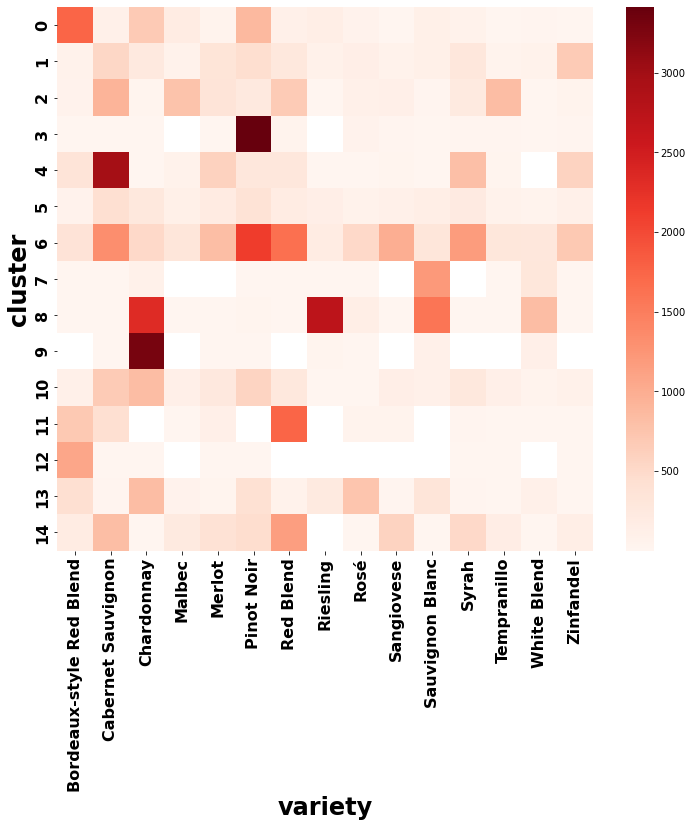

In [0]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (12, 10))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

#####Conclusion

Although kMeans didn't find a one-to-one relationship between each of the 15 wine types and clusters, we were still able to come up with clusters that greatly represented certain wines like Cabernet, Chardonay, Pinot Noir, and Riesling. This allows us to see how people are generally describing these kinds of wines, which is pretty cool! It might not have been the most useful in this case, but this type of analysis can definitely be done on other data involving reviews, etc. If we worked for a restaurant, we could determine what are some common things said in the reviews to help us know what we're doing right and what we're doing wrong so we can take action.

I didn't add any stop words for this analysis but after looking at the top 10 words in each cluster, I can think of at least a couple I could have included. For instance, the word 'flavor' appears in almost all of the clusters. I would say that this word doesn't give any useful information regarding the description so if I re-ran everything again, I would definitely add this to the stop words list. You also probably noticed that some of the descriptions actually had the wine name in them. I decided to keep these in because I was thinking that it would be easier to identify which words appeared more with certain wine varieties written in the description. The wine types can also be considered to be included in the stop words list.

Another thing to play with is the hyperparameter k i.e. the number of clusters we want the algorithm to group. For this case, I had an idea that 15 groups would be ideal since I had 15 different kinds of wine. There are many situations, however, where you don't really have an idea of how many you should pick. 8 is the default with sklearn but another way to determine k is through the use of an elbow plot, which involves the within cluster variance I mentioned earlier.